In [2]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

%matplotlib inline

In [59]:
mRNA_file = "./data/mRNA/out.tsv"
clinical_file = "./data/clinical/out.tsv"

In [4]:
t0 = time.time()
mRNA_df = pd.read_csv(mRNA_file, delimiter="\t")
print(time.time()-t0)

63.71448731422424


### Deal with Genes with Null expression values by considering:

1. drop those genes
2. replace NaN with 0s

Since genes with nulls in them have completely different histogram compared to genes without nulls in them, 
the genes with nulls are dropped

In [14]:
# First compare the histogram of genes with Null Values and the genes without

In [5]:
transposed_df = mRNA_df.set_index("gene_id").transpose()
genes_with_nulls = transposed_df.columns[transposed_df.isnull().values.any(axis=0)]
genes_without_nulls = [i for i in transposed_df.columns if i not in genes_with_nulls]

In [24]:
hist_with_nulls = transposed_df[genes_with_nulls].as_matrix().flatten()
hist_with_nulls = np.array(list(filter(lambda x: not pd.isnull(x), hist_with_nulls)))

In [25]:
print(len(hist_with_nulls))

42472332


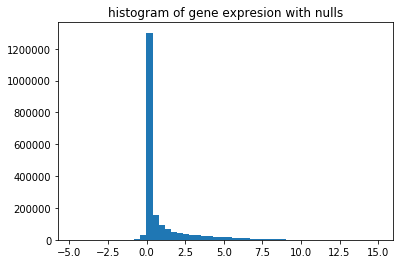

In [26]:
np.random.seed(5)
hist_with_nulls_sample = np.random.choice(hist_with_nulls, size=2000000)
hist_with_nulls_log = list(map(lambda x: np.log(x+1), hist_with_nulls_sample))
plt.hist(hist_with_nulls_log, bins=50)
plt.title("histogram of gene expresion with nulls")
plt.show()

In [19]:
def replace_with_zero(x):
    if pd.isnull(x):
        return 0
    else: return x

hist_with_nulls_replaced = hist_with_nulls = transposed_df[genes_with_nulls].as_matrix().flatten()
hist_with_nulls_replaced = np.array(list(map(replace_with_zero, hist_with_nulls_replaced)))

In [20]:
print(len(hist_with_nulls_replaced))

46445524


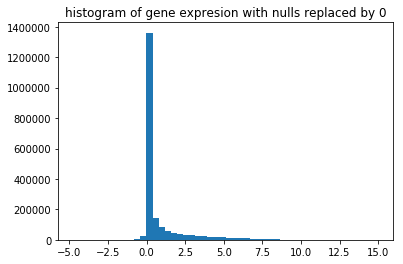

In [29]:
np.random.seed(1)
hist_with_nulls_replaced_sample = np.random.choice(hist_with_nulls_replaced, size=2000000)
hist_with_nulls_replaced_log = list(map(lambda x: np.log(x+1), hist_with_nulls_replaced_sample))
plt.hist(hist_with_nulls_replaced_log, bins=50)
plt.title("histogram of gene expresion with nulls replaced by 0")
plt.show()

In [30]:
hist_without_nulls = transposed_df[genes_without_nulls].as_matrix().flatten()

In [31]:
len(hist_without_nulls)

180812115

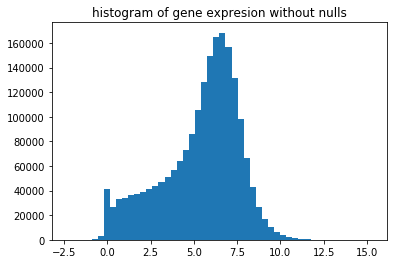

In [32]:
hist_without_nulls_sample = np.random.choice(hist_without_nulls, size=2000000)
hist_without_nulls_log = list(map(lambda x: np.log(x+1), hist_without_nulls_sample))
plt.hist(hist_without_nulls_log, bins=50)
plt.title("histogram of gene expresion without nulls")
plt.show()

### Drop nulls and log transformation

In [41]:
df = mRNA_df.dropna().set_index("gene_id").transpose()
df.index.name = "sample_id"

In [49]:
log_df = df.applymap(lambda x:np.log(x+1))

In [51]:
sample = np.random.choice(log_df.as_matrix().flatten(), size=1000000)

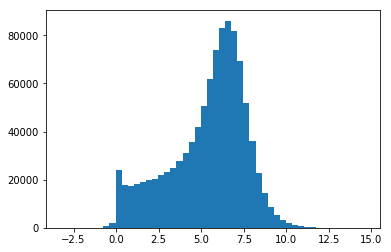

In [52]:
plt.hist(sample, bins=50)
plt.show()

In [56]:
log_df.to_csv("./data/mRNA_cleaned.csv")

### Add clinical labels to mRNA expression matrix

In [65]:
clinical_df = pd.read_csv(clinical_file, delimiter="\t", encoding="ISO-8859-1", low_memory=False)
log_df = df.from_csv("./data/mRNA_cleaned.csv")

In [125]:
tissue_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.acronym))
gender_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.gender))
try:
    log_df.insert(0, "patient_barcode", list(map(lambda x: x[:12], log_df.index)))
except ValueError:
    pass
intersection_patients = set(log_df.patient_barcode).intersection(set(clinical_df.bcr_patient_barcode))
log_df = log_df[log_df.patient_barcode.isin(intersection_patients)]

In [135]:
log_df.drop("label_tissue", axis=1, inplace=True)
log_df.drop("label_gender", axis=1, inplace=True)
log_df.insert(1, "label_tissue", log_df.patient_barcode.apply(lambda x:tissue_dict[x]))
log_df.insert(1, "label_gender", log_df.patient_barcode.apply(lambda x:gender_dict[x]))

In [137]:
log_df.to_csv("./data/mRNA_cleaned_labeled_tissue_gender.csv")

### Add tumor v.s. normal label to mRNA expression matrix
Only save primary solid tumor, solid tumor normal and metastatic

In [139]:
log_df = df.from_csv("./data/mRNA_cleaned.csv")

In [143]:
def extract_label(barcode):
    sample_code = barcode.split("-")[3][:2]
    return sample_code

In [152]:
log_df.insert(0, "sample_type", list(map(extract_label, log_df.index)))

In [153]:
log_df.sample_type.value_counts(dropna=False)

01    9706
11     737
06     395
03     173
02      46
05      11
07       1
Name: sample_type, dtype: int64

In [157]:
code_lookup = {"01": "primary solid tumor",  
               "11": "solid tissue normal",
               "06": "metastatic",
               "03": "Primary Blood Derived Cancer - Peripheral Blood",
               "02": "Recurrent Solid Tumor",
               "05": "Additional - New Primary",
               "07": "Additional Metastatic"}

In [160]:
log_df = log_df[log_df.sample_type.isin(["01", "11", "06"])]
log_df.insert(1, "label", log_df.sample_type.apply(lambda x:code_lookup[x]))

In [162]:
log_df.drop("sample_type", axis=1, inplace=True)

In [164]:
log_df.to_csv("./data/mRNA_cleaned_labeled_tumor_type.csv")

### make a master matrix with insection of all labels and samples with labels

In [4]:
df1 = pd.read_csv("./data/mRNA_cleaned_labeled_tissue_gender.csv")
df2 = pd.read_csv("./data/mRNA_cleaned_labeled_tumor_type.csv")

In [7]:
common_samples = set(df1.sample_id).intersection(df2.sample_id)
print(len(common_samples))

10799


In [11]:
joined_df = df1.set_index("sample_id").join(df2.set_index("sample_id"), rsuffix="right_")

In [21]:
joined_df.drop([i for i in joined_df.columns if "right_" in i], axis=1, inplace=True)
columns = ["label_gender", "label_tissue", "label"] + [i for i in joined_df.columns if "|" in i]
joined_df = joined_df[columns].dropna().copy()

In [25]:
joined_df.to_csv("./data/mRNA_cleaned_labeled_all.csv")

## Visualize Data in the master matrix

In [3]:
df = pd.read_csv("./data/mRNA_cleaned_labeled_all.csv", index_col="sample_id")

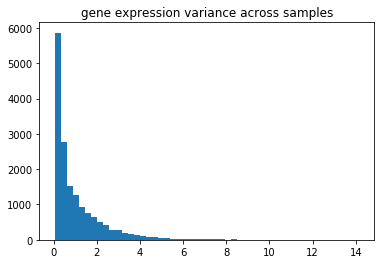

In [70]:
X = df[df.columns[3:]]
plt.hist(X.var(axis=0).as_matrix(), bins=50)
plt.title("gene expression variance across samples")
plt.show()

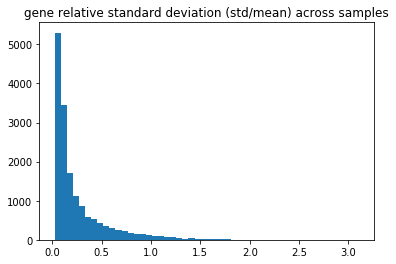

In [76]:
# coefficient of variation  (relative standard deviation distribution)
plt.hist(X.std(axis=0)/X.mean(axis=0).as_matrix(), bins=50)
plt.title("gene relative standard deviation (std/mean) across samples")
plt.show()

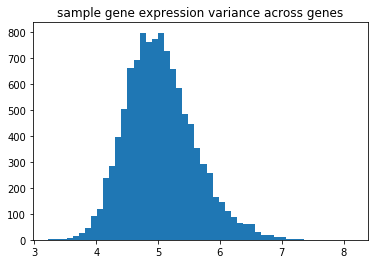

In [74]:
X = df[df.columns[3:]]
plt.hist(X.var(axis=1).as_matrix(), bins=50)
plt.title("sample gene expression variance across genes")
plt.show()

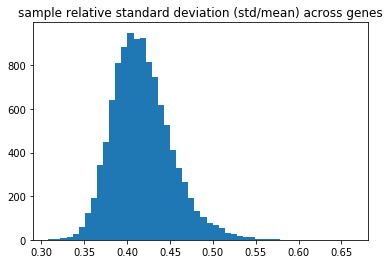

In [77]:
# coefficient of variation  (relative standard deviation distribution)
plt.hist(X.std(axis=1)/X.mean(axis=1).as_matrix(), bins=50)
plt.title("sample relative standard deviation (std/mean) across genes")
plt.show()

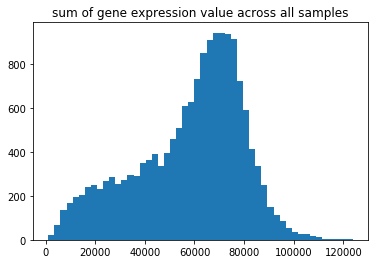

In [83]:
plt.hist(X.sum(axis=0).as_matrix(), bins=50) # gene-wise summation
plt.title("sum of gene expression value across all samples")
plt.show()

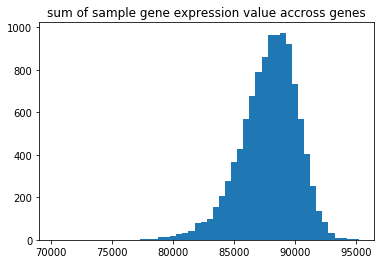

In [82]:
plt.hist(X.sum(axis=1).as_matrix(), bins=50) # sample-wise summation
plt.title("sum of sample gene expression value accross genes")
plt.show()